In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import analysis.yinf as yinf
import analysis.products as products
import analysis.util as util
from data.util import *
from geom.pdsp import VOXEL_SIZE
import os, sys, re
from scipy.stats import gaussian_kde, linregress, binned_statistic
ML_DIR = os.path.expandvars("$SCRATCH/mlreco_cell/")
NETS = dict(enumerate(sorted([d for d in os.listdir(os.path.expandvars(ML_DIR))])))
SIM_DIR = os.path.expandvars("$SCRATCH/larsim/")
SIMS = dict(enumerate(sorted([d for d in os.listdir(os.path.expandvars(SIM_DIR)) if "reco" in d])))

VOXEL_SIZE = np.array(VOXEL_SIZE)
voxel_size = VOXEL_SIZE*[8, 4, 4]

"""
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]
"""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Track fitting test

The arc is a semicircle of radius 100 with a voxel of unit "charge" every 0.005 radian, i.e. dQ/dX = 1/(100*0.005) = 2

The line segments each contain a line of voxels of unit "charge" every 0.1, i.e. dQ/dX = 1/0.1 = 10

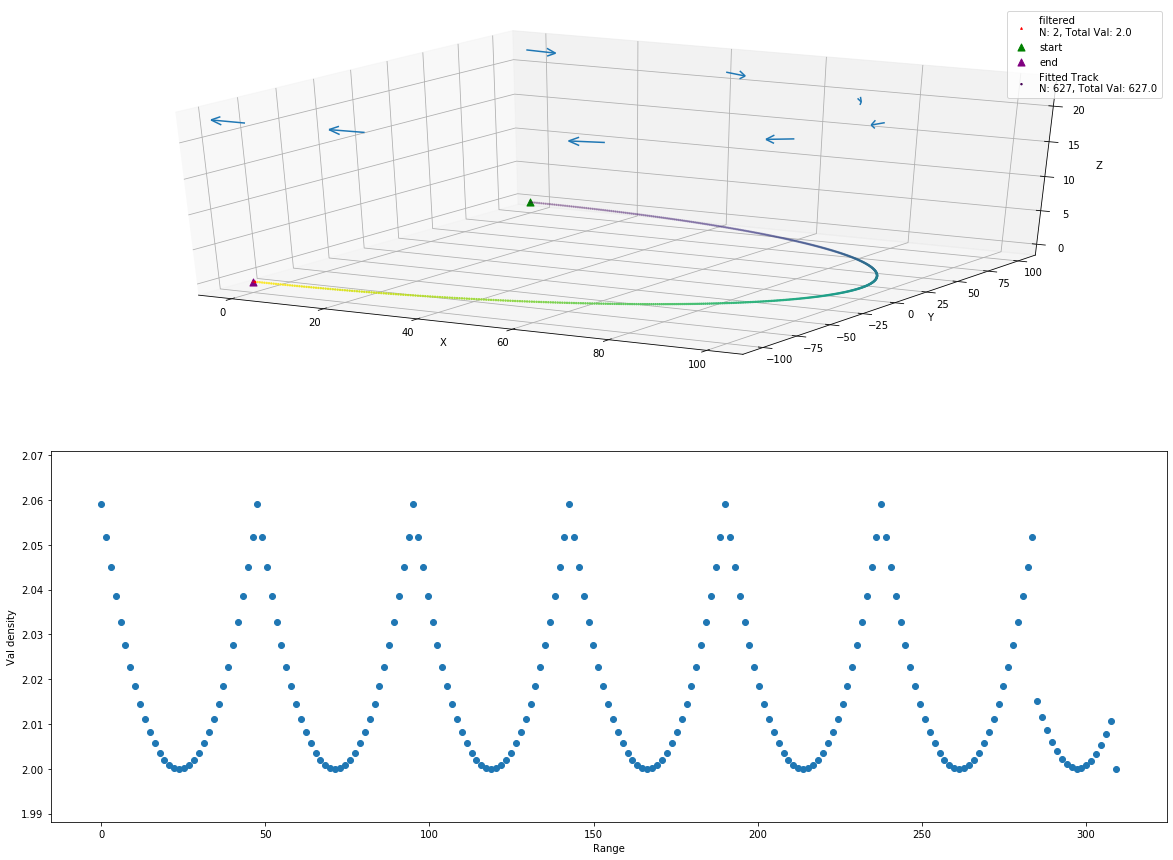

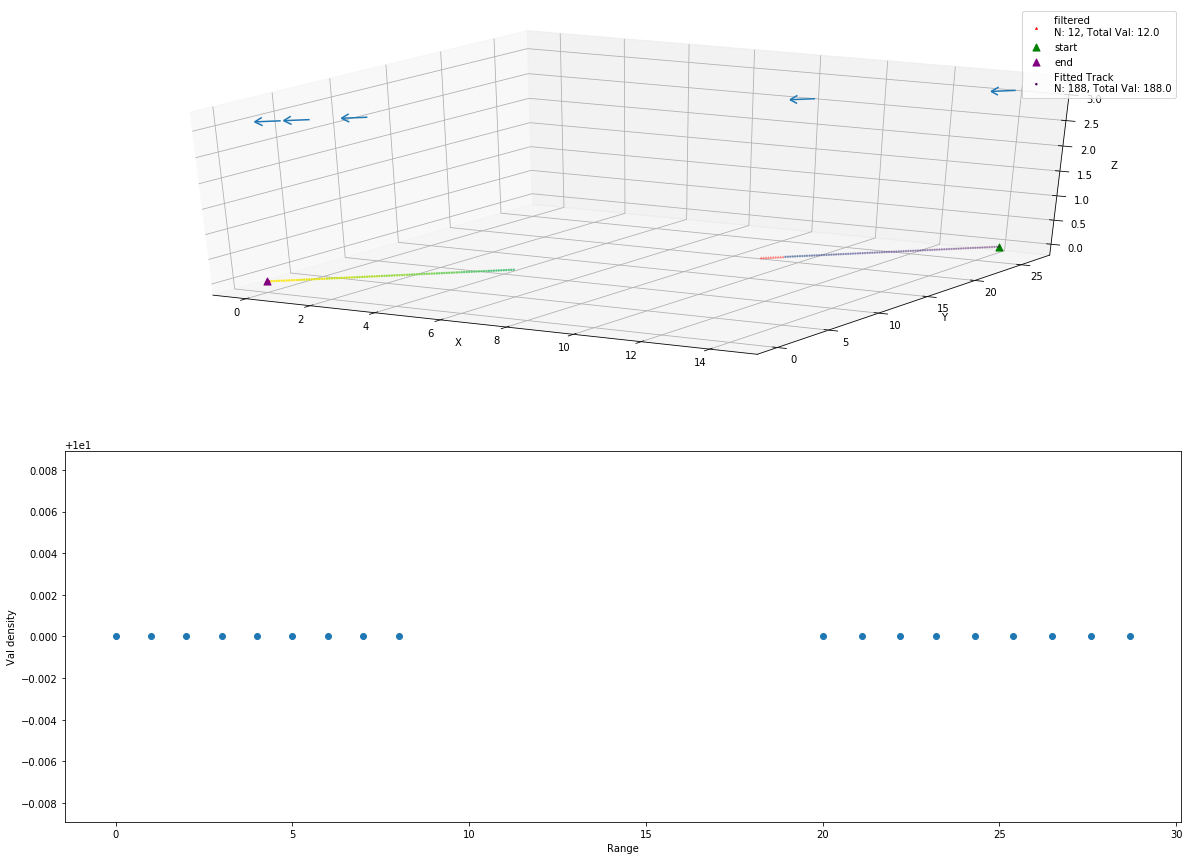

In [3]:
voxel_arc = {(100*np.sin(theta), 100*np.cos(theta), 0) : 1 for theta in np.arange(0, np.pi, 0.005)}
track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_arc, None, fig = plt.figure())
voxel_segmented = {(t*np.sin(0.5), t*np.cos(0.5), 0) : 1 for t in np.arange(0, 10, 0.1)}
voxel_segmented.update({(t*np.sin(0.5), t*np.cos(0.5), 0) : 1 for t in np.arange(20, 30, 0.1)})
track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_segmented, None, fig = plt.figure())

## SingleMu

Network Inference (Note: it's downsampled by (8,4,4) relative to others)


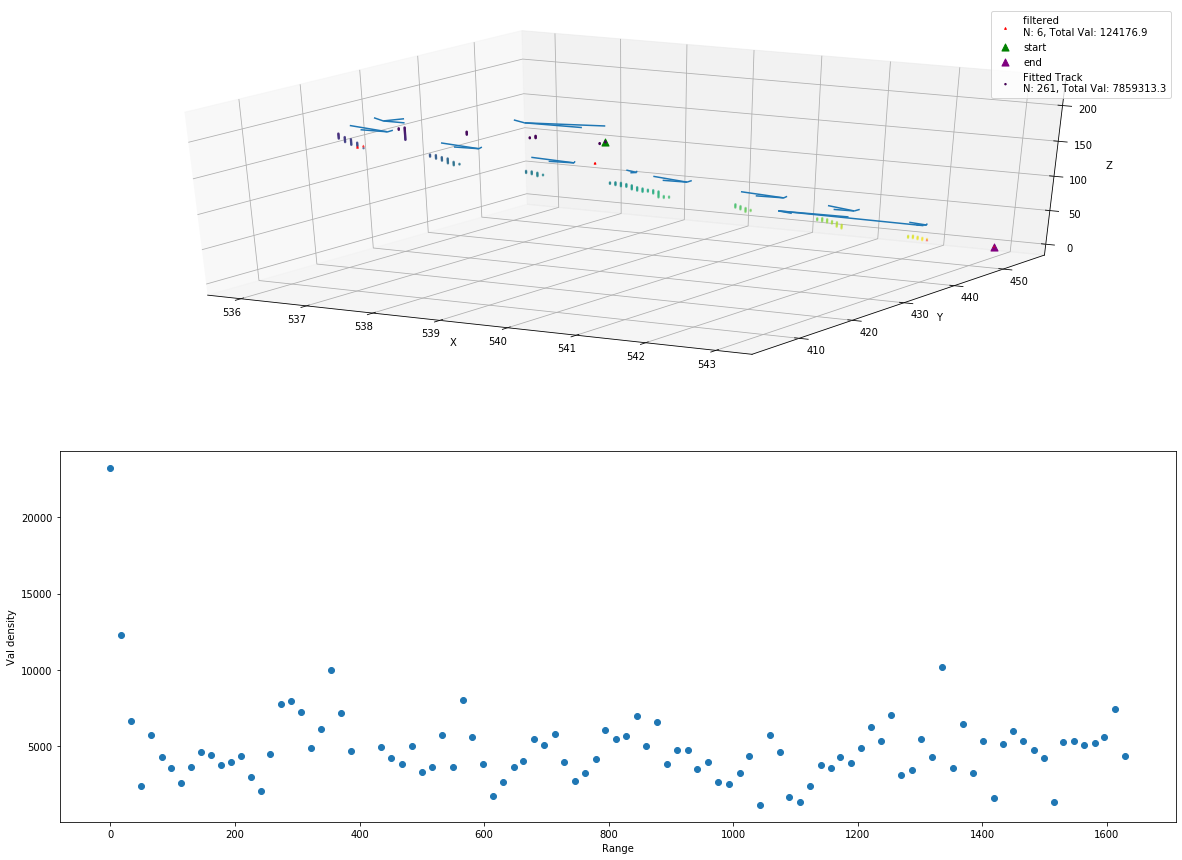

MC_truth


<Figure size 1440x1080 with 0 Axes>

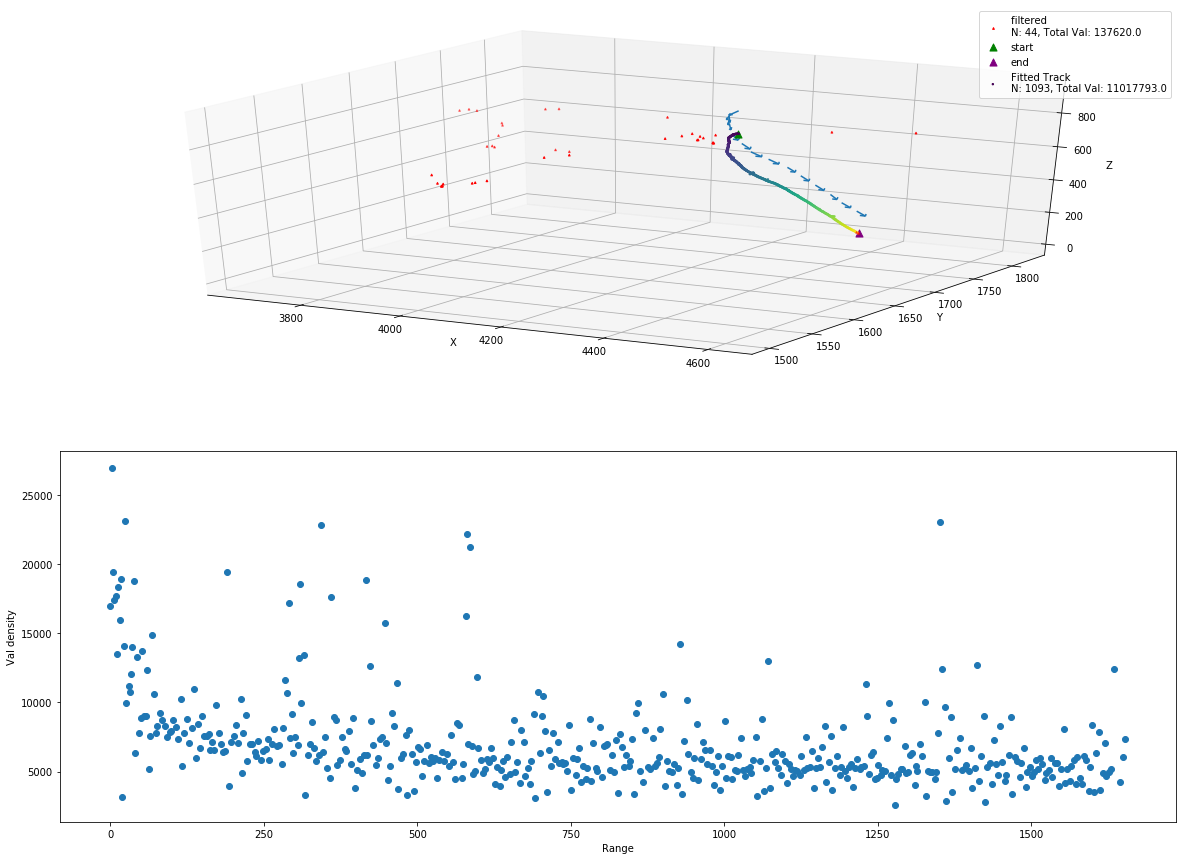

SpacePointSolver


<Figure size 1440x1080 with 0 Axes>

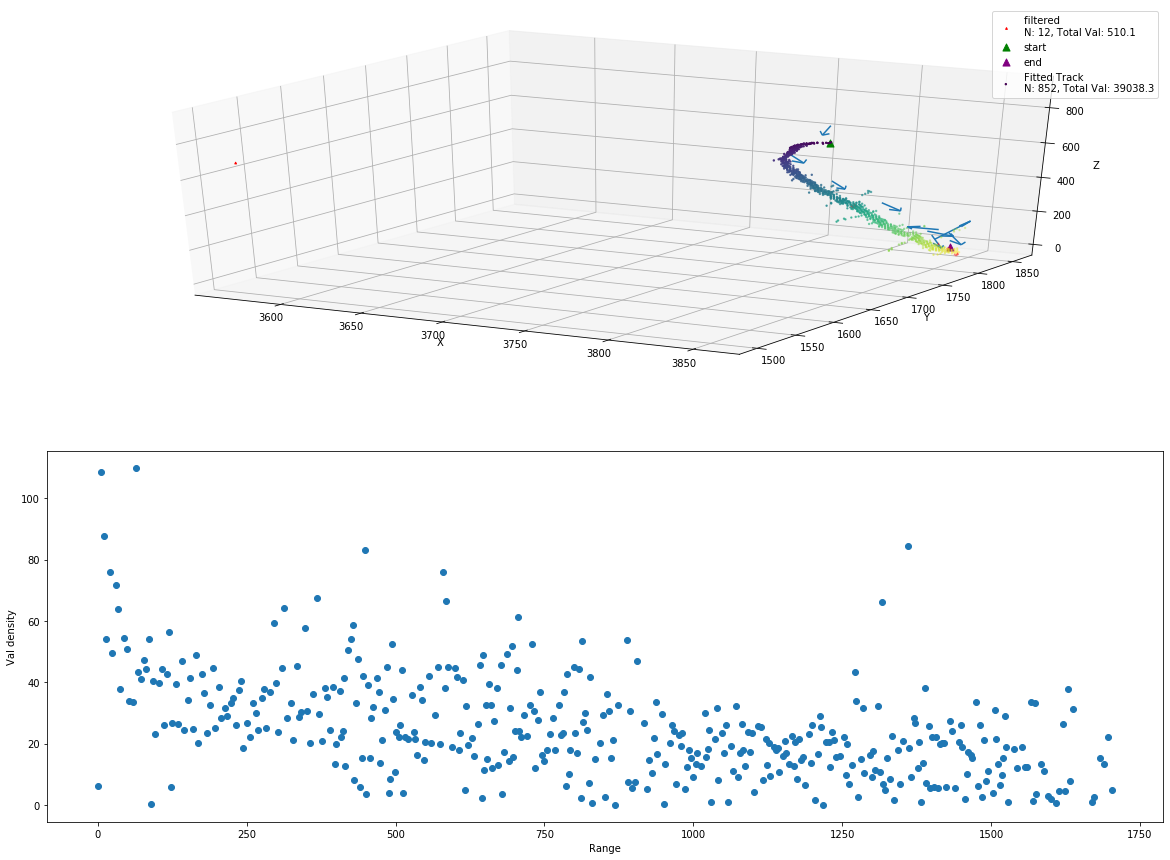

<Figure size 1440x1080 with 0 Axes>

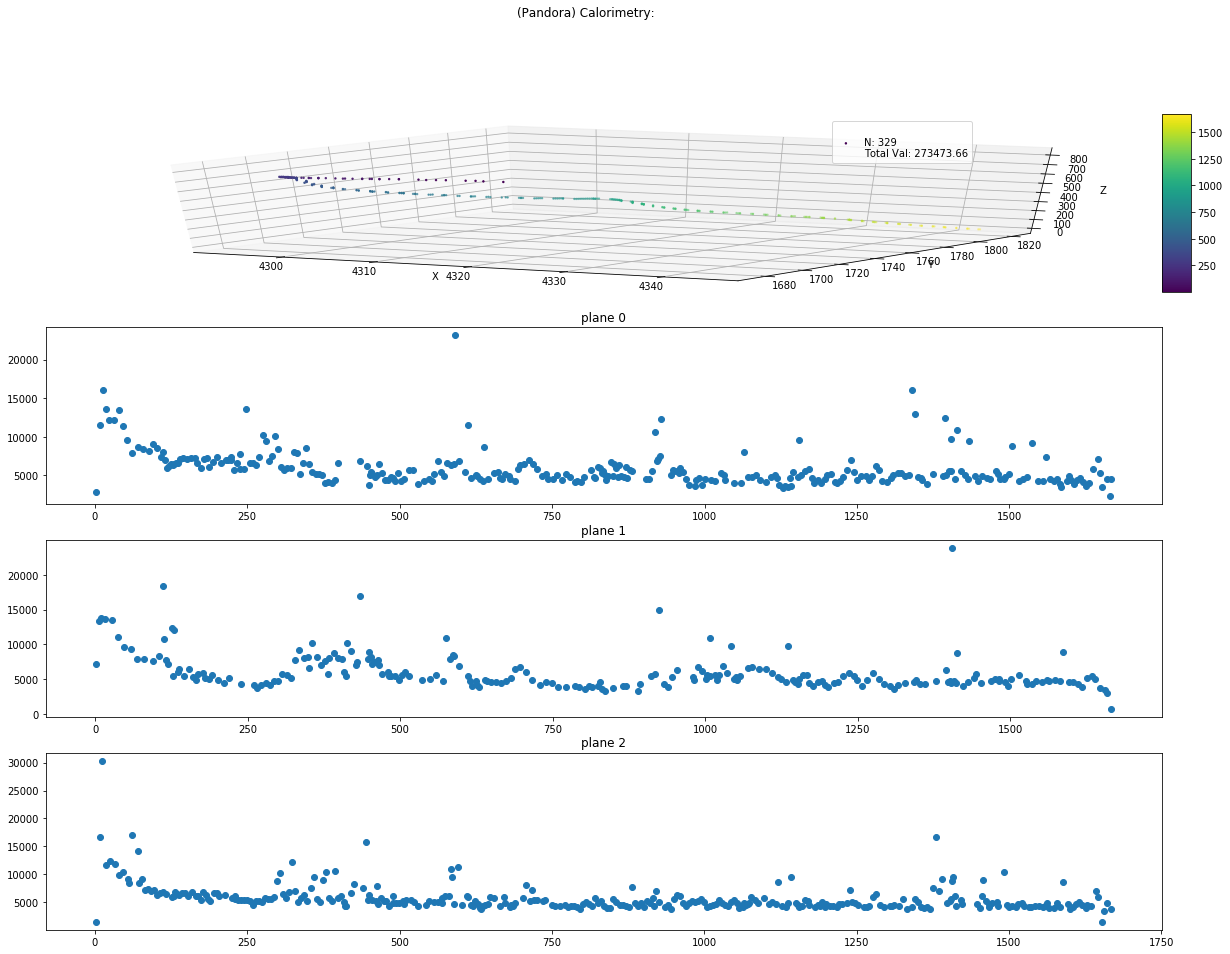

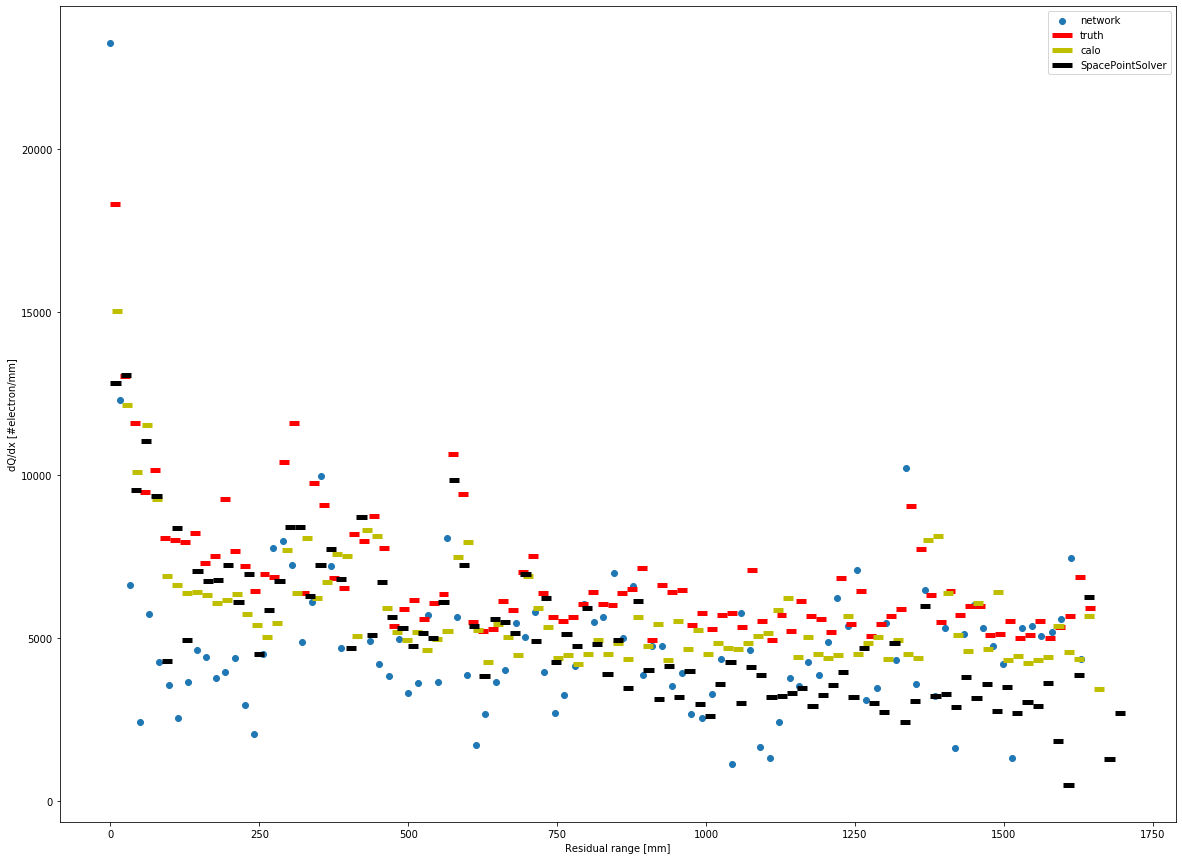

In [4]:
index = 301
event = 49
yinf_file = (ML_DIR+"singleE-BeamCosmic-depoElec-tpc1_charge-164-lr0.01/inference/epoch36-batch0-reco_singleMu_%03d_yinf-TPC5.npy"%index,
            (ML_DIR+"singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-batch0-reco_singleMu_%03d_yinf-TPC5.npy"%index, 0.35))
voxel_yinf = util.filter_voxels_coord((None, None, None), yinf.parse_yinf((event, SIM_DIR+"reco_1GeV_MuWire_xy/"), yinf_file))[0]
downsample = (1, 1, 1)
voxel_truth = util.downsample_voxels(downsample, yinf.parse_yinf(event, SIM_DIR+"reco_1GeV_Mu_parsed/reco_singleMu_%03d_depoElectron-TPC5.npz"%index), reduce=True)[0]
voxel_sp = util.downsample_voxels(downsample, yinf.parse_yinf(event, SIM_DIR+"reco_1GeV_Mu_parsed/reco_singleMu_%03d_spacepoint-TPC56.npz"%index), reduce=True)[0]

#fig=plt.figure()
#util.scatter_voxel(fig, fig.add_subplot(211, projection="3d") , voxel_truth)
#util.scatter_voxel(fig, fig.add_subplot(212, projection="3d") , voxel_yinf)

print("Network Inference (Note: it's downsampled by (8,4,4) relative to others)")
coords, _ = util.voxel_to_numpy(voxel_yinf)
coord_start = coords[np.argmin(coords[:, 2])]
track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_yinf, coord_start, voxel_size, 10, 100, 0.98, (5, 30))
track_ranges_inf, track_vals_inf, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_yinf, coord_end, voxel_size, 10, 100, 0.98, (5, 30), plt.figure())
plt.suptitle("Network Inference (Note: it's downsampled by (8,4,4) relative to others)")
bins = len(track_ranges)

print("MC_truth")
coords, _ = util.voxel_to_numpy(voxel_truth)
coord_start = coords[np.argmin(coords[:, 2])]
track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_truth, coord_start, VOXEL_SIZE*downsample, 2, 50, 0.98, (10, 100))
track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_truth, coord_end, VOXEL_SIZE*downsample, 2, 50, 0.98, (10, 100), plt.figure())
bin_means_truth, bin_edges_truth, binnumber = binned_statistic(track_ranges, track_vals, bins=bins)
plt.suptitle("MC truth")

print("SpacePointSolver")
coords, _ = util.voxel_to_numpy(voxel_sp)
coord_start = coords[np.argmin(coords[:, 2])]
track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_sp, coord_start, VOXEL_SIZE*downsample, (2, 10), 200, 0.95, (20, 200))
track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_sp, coord_end, VOXEL_SIZE*downsample, (2, 10),  200, 0.95, (20, 200), plt.figure())
bin_means_sp, bin_edges_sp, binnumber = binned_statistic(track_ranges, np.array(track_vals)*200, bins=bins)
plt.suptitle("SpacePointSolver")
"""
plt.figure()
plt.scatter(track_ranges, track_vals)
try:
    bin_means_truth, bin_edges_truth, binnumber = binned_statistic(track_ranges, track_vals, bins=bins)
    plt.hlines(bin_means_truth, bin_edges_truth[:-1], bin_edges_truth[1:], colors='purple', lw=5,
               label='binned statistic of data')
except Exception:
    pass

downsample = (8, 4, 4)
voxel_truth = util.downsample_voxels(downsample, yinf.parse_yinf(event, SIM_DIR+"reco_1GeV_Mu_parsed/reco_singleMu_%03d_depoElectron-TPC5.npz"%index), reduce=True)[0]
coords, _ = util.voxel_to_numpy(voxel_truth)
coord_start = coords[np.argmin(coords[:, 2])]
track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_truth, coord_start, voxel_size, (10, 20), 100, 0.98, (5, 30))
track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_truth, coord_end, voxel_size,(10, 20), 100, 0.98, (5, 30))     
plt.scatter(track_ranges, track_vals)
"""

with np.load(SIM_DIR+"reco_1GeV_Mu_parsed/reco_singleMu_%03d_calonosce-TPC5.npz"%index, allow_pickle=True) as f:
    voxels = []
    names = []
    voxel_planes = [{}, {}, {}]
    QvR = [[[], []] for _ in range(3)]
    QvE = [[[], []] for _ in range(3)]
    for calo in f["arr_%d"%event]:
        if len(calo) <= 3: continue
        attr, plane, energy = calo[:3]
        pts = np.vstack(calo[3:])
        pts[:, 0] -= 12
        pts[:, 5] *= 10
        pts[:, 3] *= 200/10
        voxels.append(util.downsample_voxels(downsample, {tuple(pt[:3]): pt[5] for pt in pts}, reduce=True, avg=True)[0])
        names.append(attr+" Plane %d"%plane)
        voxel_planes[plane].update(voxels[-1])
        if attr=="Track" and pts[np.argmin(pts[:, 5])][2] > 300:
            QvR[plane][1].extend(pts[:, 3])
            QvR[plane][0].extend(pts[:, 5])
            QvE[plane][1].extend(pts[:, 3])
            QvE[plane][0].extend(pts[:, 4])    
    fig = plt.figure()
    util.scatter_voxel(fig, fig.add_subplot(411, projection="3d"), voxel_planes[2])
for plane in range(3):
    ax = plt.subplot(4, 1, plane+2)
    ax.set_title("plane %d"%plane)
    plt.scatter(*QvR[plane])
    bin_means_calo, bin_edges_calo, binnumber = binned_statistic(*QvR[plane], bins=bins)
    #plt.hlines(bin_means_calo, bin_edges_calo[:-1], bin_edges_calo[1:], colors='y', lw=5,
               #label='binned statistic of data')
plt.suptitle("(Pandora) Calorimetry:")

plt.figure()
plt.scatter(track_ranges_inf, track_vals_inf, label="network")
plt.hlines(bin_means_truth, bin_edges_truth[:-1], bin_edges_truth[1:], color="r", lw=5, label='truth')
plt.hlines(bin_means_calo, bin_edges_calo[:-1], bin_edges_calo[1:], color="y", lw=5, label='calo')
plt.hlines(bin_means_sp, bin_edges_sp[:-1], bin_edges_sp[1:], lw=5, label='SpacePointSolver')
plt.xlabel("Residual range [mm]")
plt.ylabel("dQ/dx [#electron/mm]")
plt.legend()

**The following cell aggregates many events and takes a while to run. See its figures in plots_track/**

In [ ]:
index = 301
calo_plane = 2
track_ranges_inf, track_vals_inf = [], []
track_ranges_truth, track_vals_truth = [], []
track_ranges_calo, track_vals_calo = [], []
track_ranges_sp, track_vals_sp = [], []
avg_steps = []
for event in range(100):
    yinf_file = (ML_DIR+"singleE-BeamCosmic-depoElec-tpc1_charge-164-lr0.01/inference/epoch36-batch0-reco_singleMu_%03d_yinf-TPC5.npy"%index,
                (ML_DIR+"singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-batch0-reco_singleMu_%03d_yinf-TPC5.npy"%index, 0.35))
    voxel_yinf = yinf.parse_yinf((event, SIM_DIR+"reco_1GeV_MuWire_xy/"), yinf_file)
    voxel_truth = yinf.parse_yinf(event, SIM_DIR+"reco_1GeV_Mu_parsed/reco_singleMu_%03d_depoElectron-TPC5.npz"%index)
    voxel_sp = yinf.parse_yinf(event, SIM_DIR+"reco_1GeV_Mu_parsed/reco_singleMu_%03d_spacepoint-TPC56.npz"%index)
    try:
        coords, _ = util.voxel_to_numpy(voxel_yinf)
        coord_start = coords[np.argmin(coords[:, 2])]
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_yinf, coord_start, voxel_size, 10, 100, 0.98, (5, 30))
        track_ranges_inf_, track_vals_inf_, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_yinf, coord_end, voxel_size, 10, 100, 0.98, (5, 30))
        coords, _ = util.voxel_to_numpy(voxel_truth)
        coord_start = coords[np.argmin(coords[:, 2])]
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_truth, coord_start, VOXEL_SIZE, 2, 50, 0.98, (10, 100))
        track_ranges_truth_, track_vals_truth_, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_truth, coord_end, VOXEL_SIZE, 2, 50, 0.98, (10, 100))
        coords, _ = util.voxel_to_numpy(voxel_sp)
        coord_start = coords[np.argmin(coords[:, 2])]
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_sp, coord_start, VOXEL_SIZE, (2, 10), 200, 0.95, (20, 200))
        track_ranges_sp_, track_vals_sp_, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_sp, coord_end, VOXEL_SIZE, (2, 10),  200, 0.95, (20, 200))
    except Exception as e:    
        continue
    print(event)
    with np.load(SIM_DIR+"reco_1GeV_Mu_parsed/reco_singleMu_%03d_calonosce-TPC5.npz"%index, allow_pickle=True) as f:
        voxels = []
        names = []
        voxel_planes = [{}, {}, {}]
        QvR = [[[], []] for _ in range(3)]
        QvE = [[[], []] for _ in range(3)]
        for calo in f["arr_%d"%event]:
            if len(calo) <= 3: continue
            attr, plane, energy = calo[:3]
            pts = np.vstack(calo[3:])
            pts[:, 0] -= 12
            pts[:, 5] *= 10
            pts[:, 3] *= 200/10
            if plane == calo_plane and attr=="Track" and pts[np.argmin(pts[:, 5])][2] > 300:
                QvR[plane][1].extend(pts[:, 3])
                QvR[plane][0].extend(pts[:, 5])
    
    track_ranges_inf.extend(track_ranges_inf_)
    track_vals_inf.extend(track_vals_inf_)
    track_ranges_truth.extend(track_ranges_truth_)
    track_vals_truth.extend(track_vals_truth_)
    track_ranges_sp.extend(track_ranges_sp_)
    track_vals_sp.extend(np.array(track_vals_sp_)*200)
    track_ranges_calo.extend(QvR[calo_plane][0])
    track_vals_calo.extend(QvR[calo_plane][1])
    avg_steps.append(track_ranges_inf_[-1]/len(track_ranges_inf_))
    
plt.figure()
plt.scatter(track_ranges_inf, track_vals_inf, label="inf", s=5)
plt.scatter(track_ranges_truth, track_vals_truth, label="truth", s=5)
plt.scatter(track_ranges_calo, track_vals_calo, label="calo", s=5)

plt.legend()

plt.figure()
std_error_f = lambda vals: np.std(vals)/np.sqrt(len(vals))

print(np.mean(avg_steps))
bins=np.arange(0, 2000, 15)
bin_means, bin_edges, binnumber = binned_statistic(track_ranges_truth, track_vals_truth, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3, label='truth (fitted)')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_truth, track_vals_truth, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="r", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_inf, track_vals_inf, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='b', lw=3, label='inf')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_inf, track_vals_inf, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="b", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_calo, track_vals_calo, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='y', lw=3, label='calo')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_calo, track_vals_calo, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="y", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_sp, track_vals_sp, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors="black", lw=3, label='SpacePointSolver')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_sp, track_vals_sp, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="black", elinewidth=.5)

plt.xlabel("Residual range [mm]")
plt.ylabel("dQ/dx [#electron/mm]")
plt.title("singleMu dQ/dX vs. residual range")
plt.legend()

print(np.mean(track_vals_inf), np.mean(track_vals_truth), np.mean(track_vals_calo), np.mean(track_vals_sp))
plt.figure()
track_vals_inf/=np.mean(track_vals_inf)
track_vals_truth/=np.mean(track_vals_truth)
track_vals_calo/=np.mean(track_vals_calo)
track_vals_sp/=np.mean(track_vals_sp)
bin_means, bin_edges, binnumber = binned_statistic(track_ranges_truth, track_vals_truth, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3, label='truth (fitted)')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_truth, track_vals_truth, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="r", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_inf, track_vals_inf, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='b', lw=3, label='inf')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_inf, track_vals_inf, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="b", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_calo, track_vals_calo, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='y', lw=3, label='calo')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_calo, track_vals_calo, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="y", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_sp, track_vals_sp, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='black', lw=3, label='SpacePointSolver')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_sp, track_vals_sp, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="black", elinewidth=.5)

plt.xlabel("Residual range [mm]")
plt.ylabel("dQ/dx [normalized]")
plt.title("singleMu normalized dQ/dX vs. residual range ")
plt.legend()

## BeamCosmic

Network Inference (downsampled by 8,4,4)


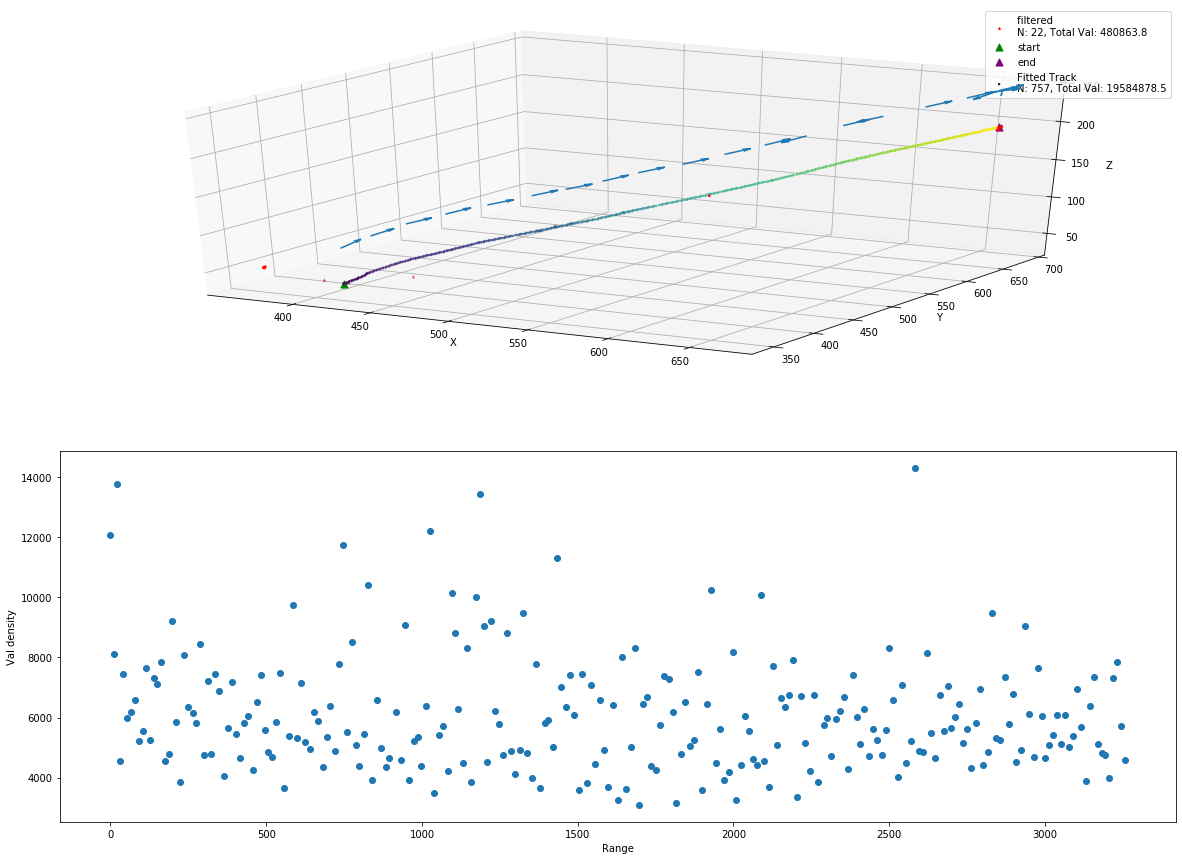

MC truth


<Figure size 1440x1080 with 0 Axes>

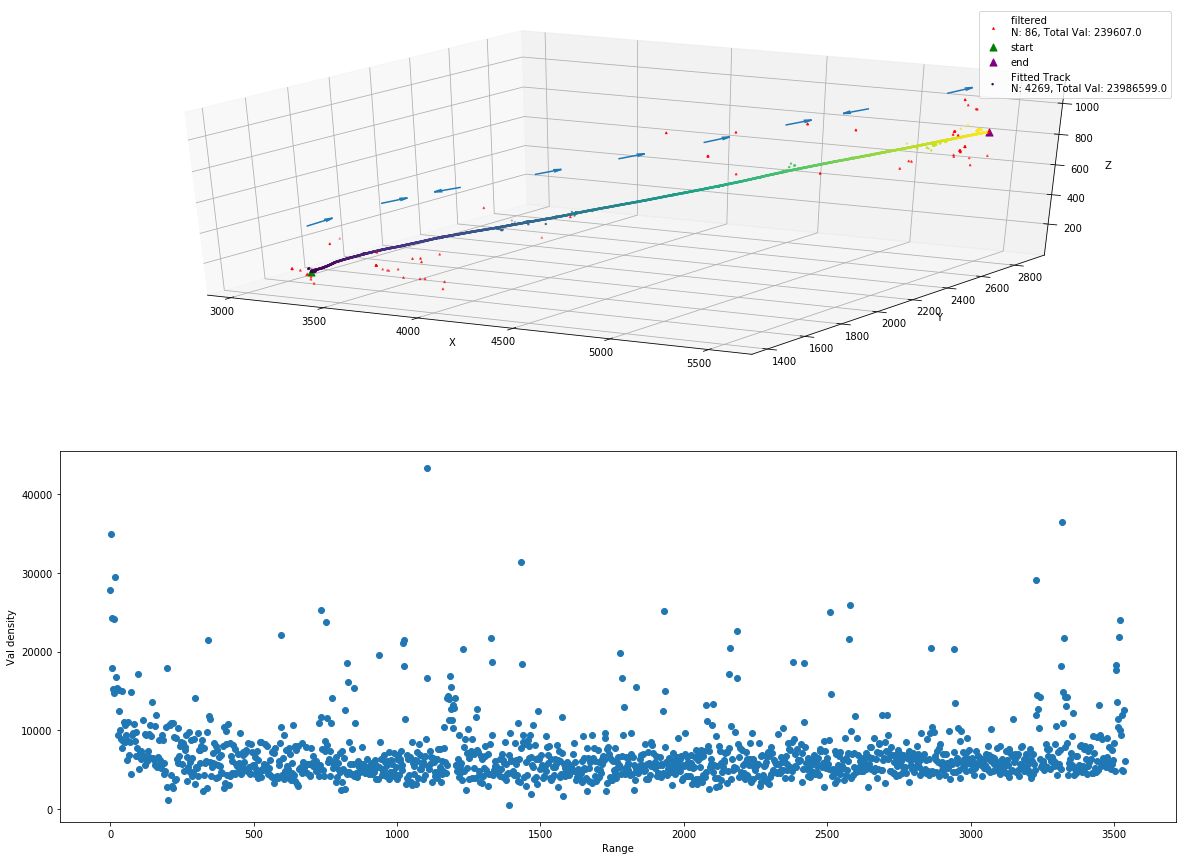

<Figure size 1440x1080 with 0 Axes>

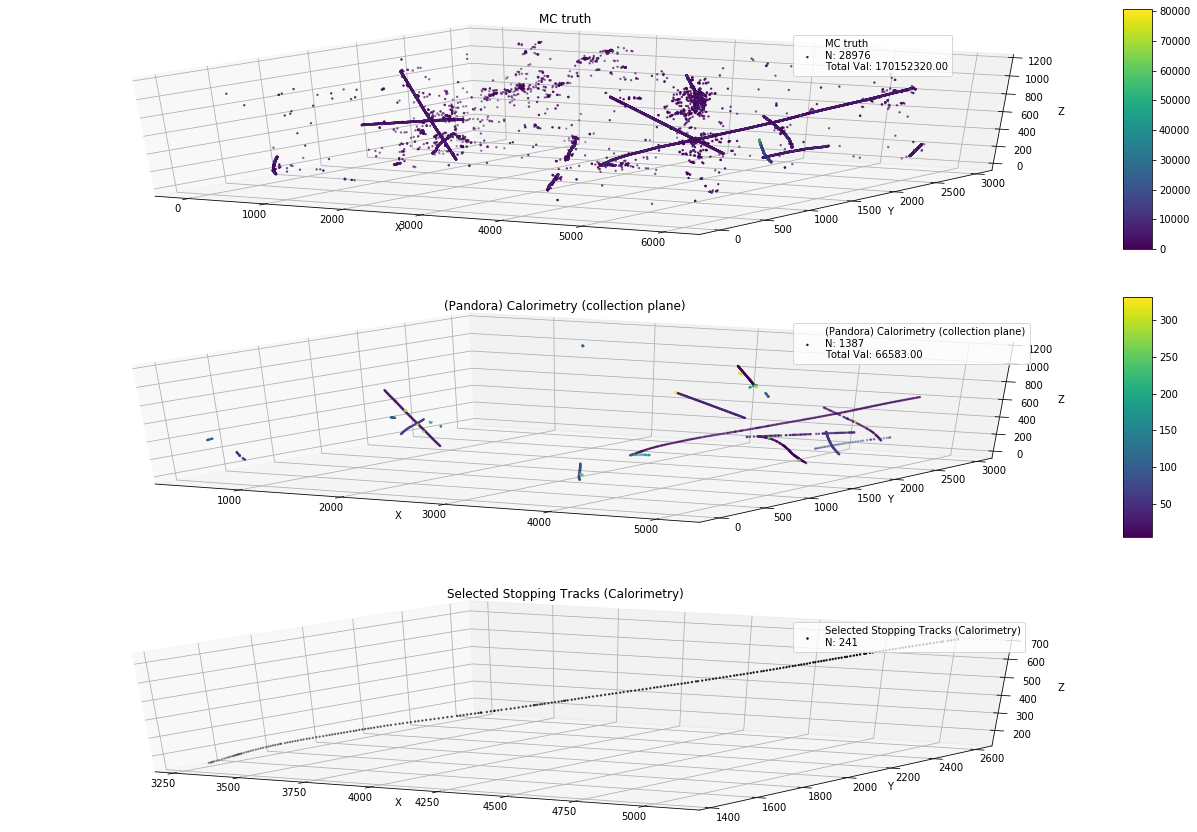

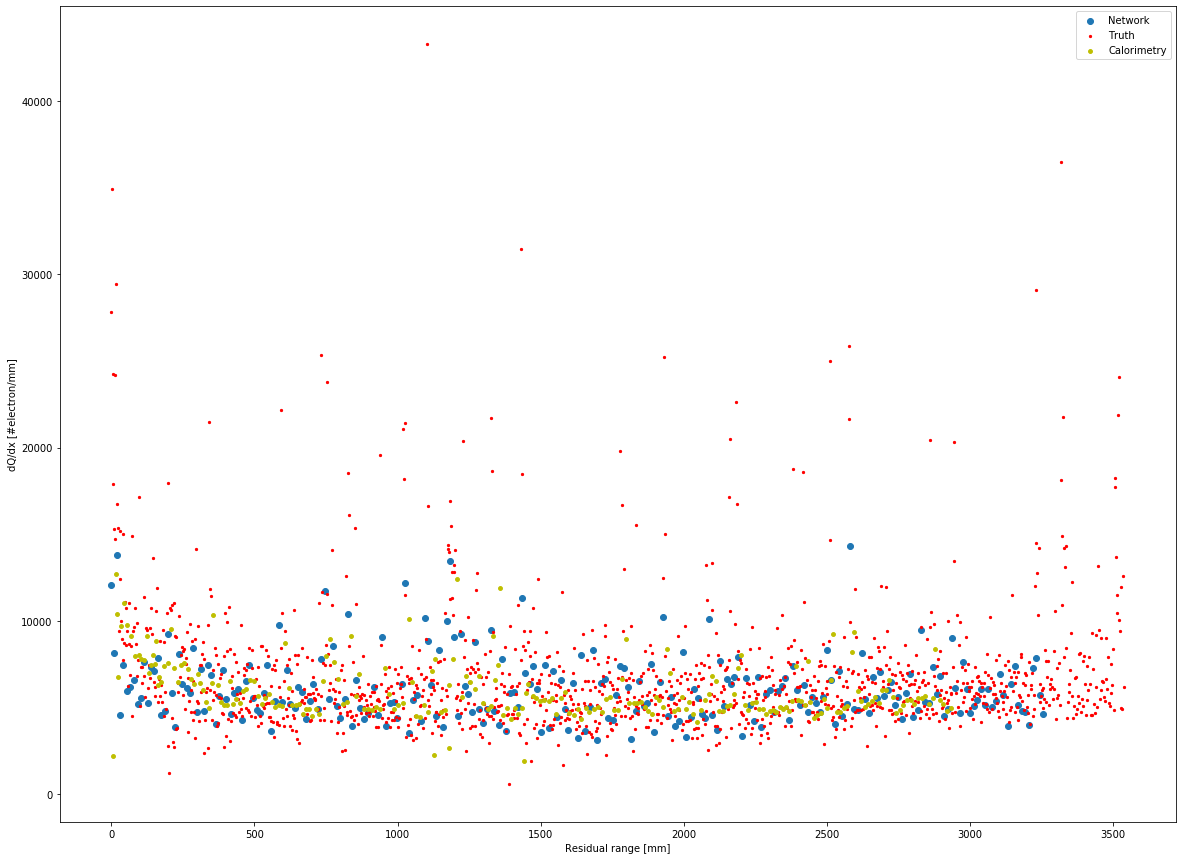

In [5]:
[(1, 0), (3, 2), (50,4)]
index = 50
event = 4
yinf_file = (ML_DIR+"singleE-BeamCosmic-depoElec-tpc1_charge-164-lr0.01/inference/epoch36-batch0-reco_BeamCosmic_%03d_yinf-TPC1.npy"%index,
            (ML_DIR+"singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-batch0-reco_BeamCosmic_%03d_yinf-TPC1.npy"%index, 0.35))
voxel_yinf = yinf.parse_yinf((event, SIM_DIR+"reco_1GeV_BeamCosmic-depoElec_xy/"), yinf_file)
voxel_truth = yinf.parse_yinf(event, SIM_DIR+"reco_1GeV_BeamCosmic_parsed/reco_BeamCosmic_%03d_depoElectron-TPC1.npz"%index)

tpc_lims = np.array((3585//(1.565/2), 5984//2, 2300//2))
with np.load(SIM_DIR+"reco_1GeV_BeamCosmic_parsed/reco_BeamCosmic_%03d_calonosce-TPC1.npz"%index, allow_pickle=True) as f:
    voxel_planes, voxel_planes_downsampled = [{}, {}, {}], [{}, {}, {}]
    QvR_calo, QvE = [{}, {}, {}], [{}, {}, {}]
    for i, calo in enumerate(f["arr_%d"%event]):
        if len(calo) <= 3: continue
        attr, plane, energy = calo[:3]
        pts = np.vstack(calo[3:])
        pts[:, 0] -= 12
        pts[:, 5] *= 10
        pts[:, 3] *= 200/10
        in_tpc = np.all((tpc_lims-pts[np.argmin(pts[:, 5])][:3])>100) and np.all(pts[np.argmin(pts[:, 5])][:3]>100)
        voxel_planes[plane].update({tuple(pt[:3]): i for pt in pts})
        voxel_planes_downsampled[plane].update({tuple(pt[:3]//(8, 4, 4)): i for pt in pts})
        if attr=="Track" and np.min(pts[:, 5]) < 10 and in_tpc and len(calo)>100:
            QvR_calo[plane][i] = [pts[:, 5], pts[:, 3]]
            QvE[plane][i] = [pts[:, 4], pts[:, 3]]

def cluster_coords(coords, voxel_mc, max_dist=np.inf):
    from scipy.spatial import KDTree
    coords_mc = list(voxel_mc.keys())
    vals_mc = list(voxel_mc.values())
    kd_tree = KDTree(coords_mc)
    dists, closest_i = kd_tree.query(coords, 1, 0)
    clusters = {val_mc : [[], []] for val_mc in vals_mc}
    for coord, closest, dist in zip(coords, closest_i, dists):
        #mc = util.mode1d([vals_mc[i] for i in closest])
        if dist > max_dist: continue
        mc = vals_mc[closest]
        clusters[mc][0].append(coord)
    for coord in set(voxel_mc.keys()).difference(coords):
        clusters[voxel_mc[coord]][1].append(coord)
    return clusters

QvR_inf, QvR_truth = {}, {}

print("Network Inference (downsampled by 8,4,4)")
clusters = cluster_coords(list(voxel_yinf.keys()), voxel_planes_downsampled[2], 50)
for mc, coords in clusters.items():
    if len(coords[1]) > 50:
        QvR_calo[2].pop(mc, None)
exception_i = []
for i, qvr in QvR_calo[2].items():
    voxel_i = util.filter_voxels_coords(clusters[i][0], voxel_yinf)[0]
    try:
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, None, voxel_size, 10, 100, 0.95, (5, 50))
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, coord_end, voxel_size, 10, 100, 0.95, (5, 50), True)
        QvR_inf[i] = [track_ranges, track_vals]
        plt.suptitle("Network Inference (downsampled by 8,4,4)")
    except Exception:
        exception_i.append(i)
        #fig=plt.figure()
        #util.scatter_voxel(fig, fig.add_subplot(211, projection="3d") , voxel_i)
for i in exception_i:
    del QvR_calo[2][i]

print("MC truth")
exception_i = []
clusters = cluster_coords(list(voxel_truth.keys()), voxel_planes[2], 500)
for mc, coords in clusters.items():
    if len(coords[1]) > 500:
        QvR_calo[2].pop(mc, None)
        
for i, qvr in QvR_calo[2].items():
    voxel_i = util.filter_voxels_coords(clusters[i][0], voxel_truth)[0]
    try:
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, None, VOXEL_SIZE, 2, 100, 0.95, (20, 500))
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, coord_end, VOXEL_SIZE, 2, 100, 0.95, (20, 500), True)
        QvR_truth[i] = [track_ranges, track_vals]
        plt.suptitle("MC truth")
    except Exception:
        exception_i.append(i)
        #fig=plt.figure()
        #util.scatter_voxel(fig, fig.add_subplot(211, projection="3d") , voxel_i)
for i in exception_i:
    del QvR_calo[2][i]
    del QvR_inf[i]
    
fig = plt.figure()
util.scatter_voxel(fig, fig.add_subplot(311, projection="3d"), voxel_truth, "MC truth")
util.scatter_voxel(fig, fig.add_subplot(312, projection="3d"), voxel_planes[2], "(Pandora) Calorimetry (collection plane)")
util.scatter_voxel(fig, fig.add_subplot(313, projection="3d"), {c: None for c in voxel_planes[2] if voxel_planes[2][c] in QvR_calo[2]}, "Selected Stopping Tracks (Calorimetry)")

for i in QvR_calo[2]:
    plt.figure()
    track_ranges, track_vals = QvR_inf[i]
    bins = len(track_ranges)
    plt.scatter(track_ranges, track_vals, label="Network")
    track_ranges, track_vals = QvR_truth[i]
    plt.scatter(track_ranges, track_vals, color="r", label="Truth", s=5)
    bin_means, bin_edges, binnumber = binned_statistic(track_ranges, track_vals, bins=bins)
    #plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], color="r", lw=5, label='truth')
    track_ranges, track_vals = QvR_calo[2][i]
    plt.scatter(track_ranges, track_vals, color="y", label="Calorimetry", s=15)
    bin_means, bin_edges, binnumber = binned_statistic(track_ranges, track_vals, bins=bins)
    #plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], color="y", lw=5, label='calo')
    plt.xlabel("Residual range [mm]")
    plt.ylabel("dQ/dx [#electron/mm]")
    plt.legend()

**The following cell aggregates many events and takes a while to run. See its figures in plots_track/**

In [ ]:
from itertools import product
track_ranges_inf, track_vals_inf = [], []
track_ranges_truth, track_vals_truth = [], []
track_ranges_calo, track_vals_calo = [], []
avg_steps = []
                
def cluster_coords(coords, voxel_mc, max_dist=np.inf):
    from scipy.spatial import KDTree
    coords_mc = list(voxel_mc.keys())
    vals_mc = list(voxel_mc.values())
    kd_tree = KDTree(coords_mc)
    dists, closest_i = kd_tree.query(coords, 1, 0)
    clusters = {val_mc : [[], []] for val_mc in vals_mc}
    for coord, closest, dist in zip(coords, closest_i, dists):
        #mc = util.mode1d([vals_mc[i] for i in closest])
        if dist > max_dist: continue
        mc = vals_mc[closest]
        clusters[mc][0].append(coord)
    for coord in set(voxel_mc.keys()).difference(coords):
        clusters[voxel_mc[coord]][1].append(coord)
    return clusters

for index, event in product(range(1, 50), range(5)):
    yinf_file = (ML_DIR+"singleE-BeamCosmic-depoElec-tpc1_charge-164-lr0.01/inference/epoch36-batch0-reco_BeamCosmic_%03d_yinf-TPC1.npy"%index,
                (ML_DIR+"singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-batch0-reco_BeamCosmic_%03d_yinf-TPC1.npy"%index, 0.35))
    
    try:
        voxel_yinf = yinf.parse_yinf((event, SIM_DIR+"reco_1GeV_BeamCosmic-depoElec_xy/"), yinf_file)
        voxel_truth = yinf.parse_yinf(event, SIM_DIR+"reco_1GeV_BeamCosmic_parsed/reco_BeamCosmic_%03d_depoElectron-TPC1.npz"%index)
    except Exception:
        continue

    tpc_lims = np.array((3585//(1.565/2), 5984//2, 2300//2))
    with np.load(SIM_DIR+"reco_1GeV_BeamCosmic_parsed/reco_BeamCosmic_%03d_calonosce-TPC1.npz"%index, allow_pickle=True) as f:
        voxel_planes, voxel_planes_downsampled = [{}, {}, {}], [{}, {}, {}]
        QvR_calo, QvE = [{}, {}, {}], [{}, {}, {}]
        for i, calo in enumerate(f["arr_%d"%event]):
            if len(calo) <= 3: continue
            attr, plane, energy = calo[:3]
            if plane != 2: continue
            pts = np.vstack(calo[3:])
            pts[:, 0] -= 12
            pts[:, 5] *= 10
            pts[:, 3] *= 200/10
            in_tpc = np.all((tpc_lims-pts[np.argmin(pts[:, 5])][:3])>100) and np.all(pts[np.argmin(pts[:, 5])][:3]>100)
            voxel_planes[plane].update({tuple(pt[:3]): i for pt in pts})
            voxel_planes_downsampled[plane].update({tuple(pt[:3]//(8, 4, 4)): i for pt in pts})
            if attr=="Track" and np.min(pts[:, 5]) < 10 and in_tpc and len(calo)>100:
                QvR_calo[plane][i] = [pts[:, 5], pts[:, 3]]
                QvE[plane][i] = [pts[:, 4], pts[:, 3]]
                
    QvR_inf, QvR_truth = {}, {}
    clusters = cluster_coords(list(voxel_yinf.keys()), voxel_planes_downsampled[2], 50)
    for mc, coords in clusters.items():
        if len(coords[1]) > 50:
            QvR_calo[2].pop(mc, None)

    exception_i = []
    for i, qvr in QvR_calo[2].items():
        voxel_i = util.filter_voxels_coords(clusters[i][0], voxel_yinf)[0]
        try:
            track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, None, voxel_size, 10, 100, 0.95, (5, 50))
            track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, coord_end, voxel_size, 10, 100, 0.95, (5, 50))
            QvR_inf[i] = [track_ranges, track_vals]
        except Exception:
            exception_i.append(i)
    for i in exception_i:
        del QvR_calo[2][i]

    exception_i = []
    clusters = cluster_coords(list(voxel_truth.keys()), voxel_planes[2], 500)
    for mc, coords in clusters.items():
        if len(coords[1]) > 500:
            QvR_calo[2].pop(mc, None)

    for i, qvr in QvR_calo[2].items():
        voxel_i = util.filter_voxels_coords(clusters[i][0], voxel_truth)[0]
        try:
            track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, None, VOXEL_SIZE, 2, 100, 0.95, (20, 500))
            track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, coord_end, VOXEL_SIZE, 2, 100, 0.95, (20, 500))
            QvR_truth[i] = [track_ranges, track_vals]
        except Exception:
            exception_i.append(i)
    for i in exception_i:
        del QvR_calo[2][i]
        del QvR_inf[i]
    
    for i in QvR_calo[2]:
        track_ranges_inf.extend(QvR_inf[i][0])
        track_vals_inf.extend(QvR_inf[i][1])
        track_ranges_truth.extend(QvR_truth[i][0])
        track_vals_truth.extend(QvR_truth[i][1])
        track_ranges_calo.extend(QvR_calo[2][i][0])
        track_vals_calo.extend(QvR_calo[2][i][1])
        avg_steps.append(QvR_inf[i][0][-1]/len(QvR_inf[i][0]))
    
plt.figure()
plt.scatter(track_ranges_inf, track_vals_inf, label="inf", s=5)
plt.scatter(track_ranges_truth, track_vals_truth, label="truth", s=5)
plt.scatter(track_ranges_calo, track_vals_calo, label="calo", s=5)
plt.legend()

plt.figure()
std_error_f = lambda vals: np.std(vals)/np.sqrt(len(vals))

print(np.mean(avg_steps))
bins=np.arange(0, 2000, 15)
bin_means, bin_edges, binnumber = binned_statistic(track_ranges_truth, track_vals_truth, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3, label='truth (fitted)')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_truth, track_vals_truth, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="r", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_inf, track_vals_inf, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='b', lw=3, label='inf')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_inf, track_vals_inf, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="b", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_calo, track_vals_calo, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='y', lw=3, label='calo')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_calo, track_vals_calo, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="y", elinewidth=.5)

plt.xlabel("Residual range [mm]")
plt.ylabel("dQ/dx [#electron/mm]")
plt.title("BeamCosmic dQ/dX vs. residual range")
plt.legend()

print(np.mean(track_vals_inf), np.mean(track_vals_truth), np.mean(track_vals_calo))
plt.figure()
track_vals_inf/=np.mean(track_vals_inf)
track_vals_truth/=np.mean(track_vals_truth)
track_vals_calo/=np.mean(track_vals_calo)
bin_means, bin_edges, binnumber = binned_statistic(track_ranges_truth, track_vals_truth, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3, label='truth (fitted)')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_truth, track_vals_truth, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="r", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_inf, track_vals_inf, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='b', lw=3, label='inf')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_inf, track_vals_inf, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="b", elinewidth=.5)

bin_means, bin_edges, binnumber = binned_statistic(track_ranges_calo, track_vals_calo, bins=bins)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='y', lw=3, label='calo')
bin_SDs, bin_edges, binnumber = binned_statistic(track_ranges_calo, track_vals_calo, bins=bins, statistic=std_error_f)
plt.errorbar((bin_edges[:-1] + bin_edges[1:])/2, bin_means, bin_SDs, visible=False, ecolor="y", elinewidth=.5)

plt.xlabel("Residual range [mm]")
plt.ylabel("dQ/dx [normalized]")
plt.title("BeamCosmic normalized dQ/dX vs. residual range ")
plt.legend()

## ProtoDUNE

SpacePointSolver:


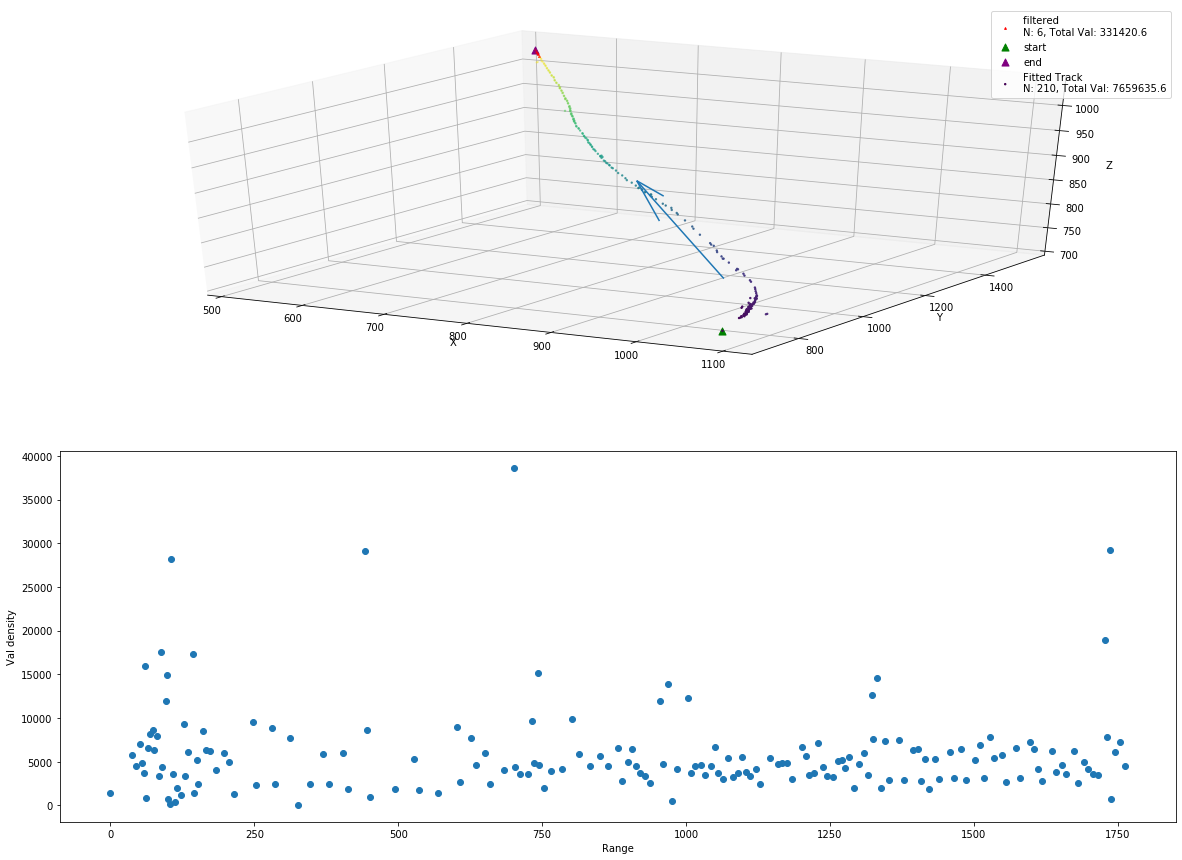

Network


<Figure size 1440x1080 with 0 Axes>

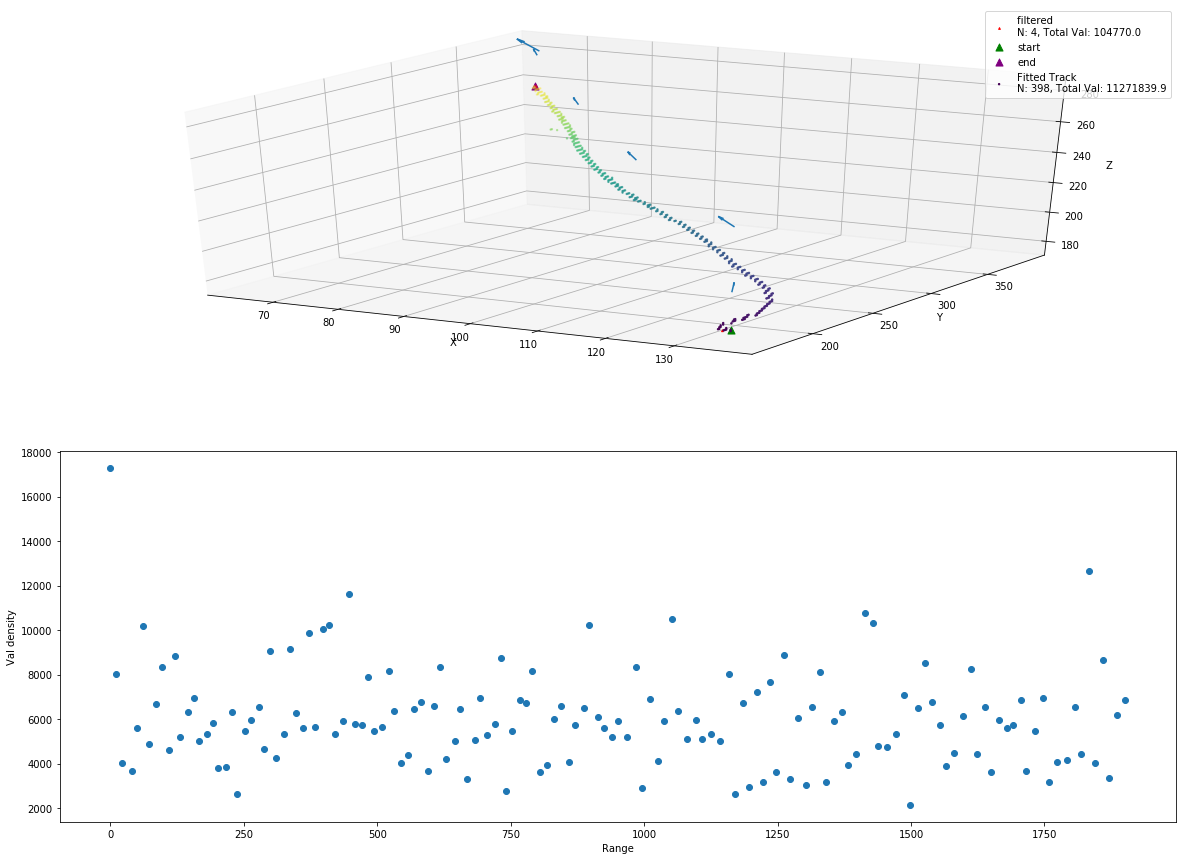

<Figure size 1440x1080 with 0 Axes>

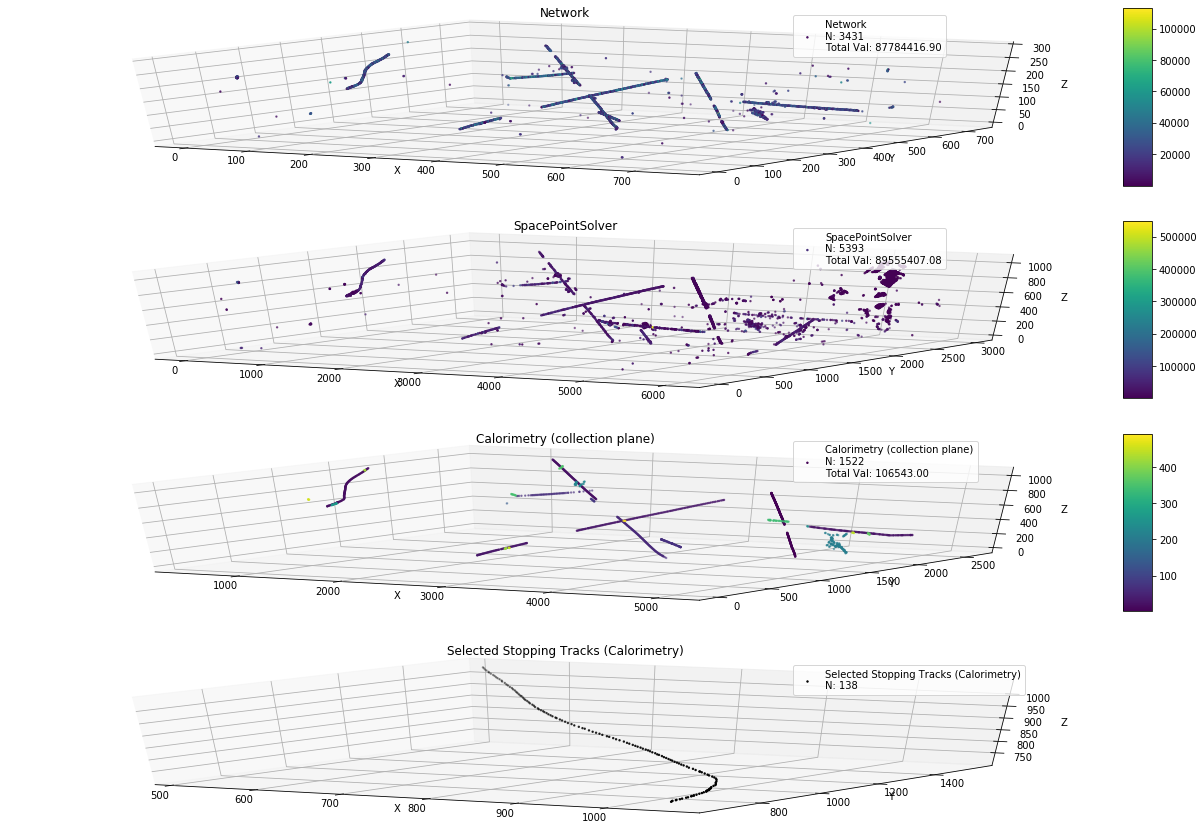

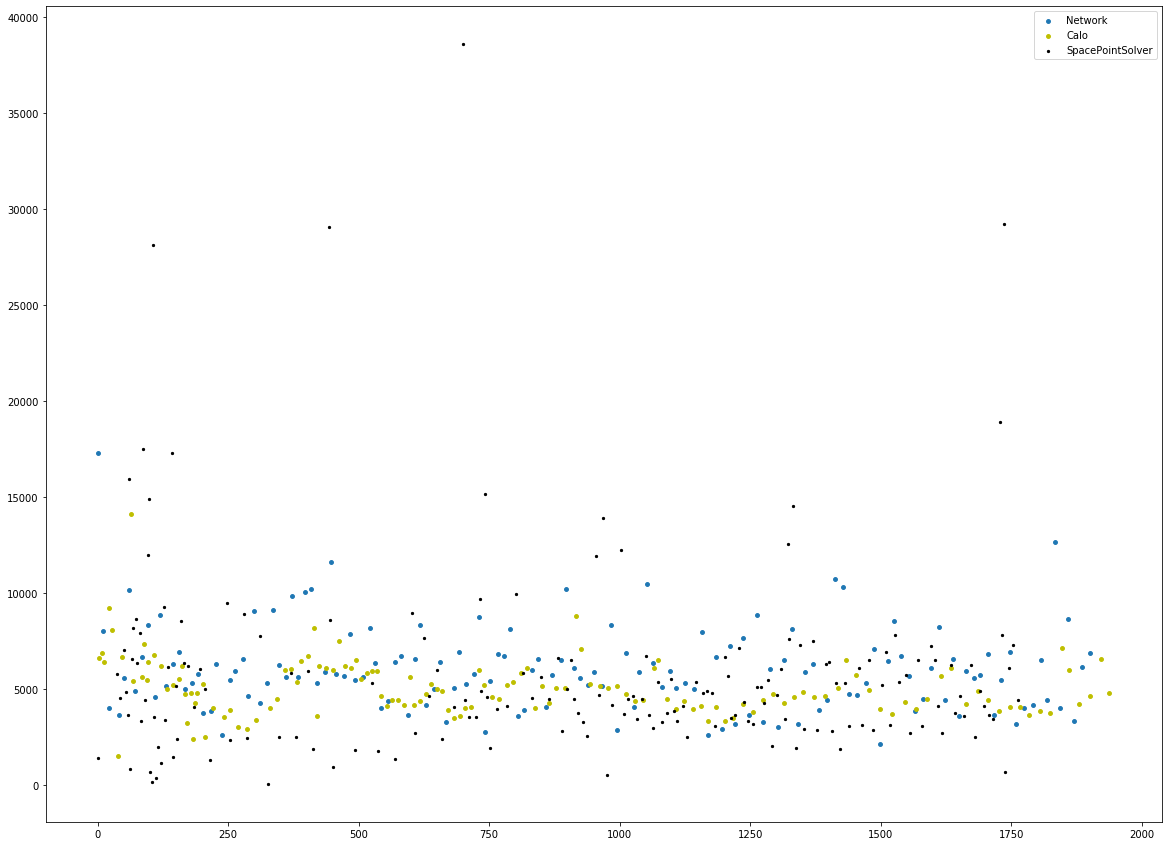

In [6]:
[(9, 21), (9, 24), (9, 29), (9, 31)]

index = 9
event = 31
yinf_file = (ML_DIR+"singleE-BeamCosmic-depoElec-tpc1_charge-164-lr0.01/inference/epoch36-batch0-reco_protoDUNE_%04d_yinf-TPC1.npy"%index,
            (ML_DIR+'singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-batch0-reco_protoDUNE_%04d_yinf-TPC1.npy'%index, 0.35))
voxel_yinf = yinf.parse_yinf((event, SIM_DIR+"protoDUNE_xy/"), yinf_file)
voxel_sp = yinf.parse_yinf(event, SIM_DIR+"protoDUNE_parsed/reco_protoDUNE_%04d_spacepoint-TPC12.npz"%index)
voxel_sp = util.filter_voxels_coord(((0, 6000), None, None), {(c[0]+(244*2), c[1], c[2]): v*200 for c, v in voxel_sp.items()})[0]
#voxel_sp = util.filter_voxel_val(voxel_sp, 10)

tpc_lims = np.array((3585//(1.565/2), 5984//2, 2300//2))
with np.load(SIM_DIR+"protoDUNE_parsed/reco_protoDUNE_%04d_calo-TPC1.npz"%index, allow_pickle=True) as f:
    voxel_planes, voxel_planes_downsampled = [{}, {}, {}], [{}, {}, {}]
    QvR_calo, QvE = [{}, {}, {}], [{}, {}, {}]
    for i, calo in enumerate(f["arr_%d"%event]):
        if len(calo) <= 3: continue
        attr, plane, energy = calo[:3]
        pts = np.vstack(calo[3:])
        pts[:, 0] -= 12
        pts[:, 5] *= 10
        pts[:, 3] *= 200/10
        in_tpc = np.all((tpc_lims-pts[np.argmin(pts[:, 5])][:3])>100) and np.all(pts[np.argmin(pts[:, 5])][:3]>100)
        voxel_planes[plane].update({tuple(pt[:3]): i for pt in pts})
        voxel_planes_downsampled[plane].update({tuple(pt[:3]//(8, 4, 4)): i for pt in pts})
        if attr=="Track" and np.min(pts[:, 5]) < 10 and in_tpc and len(calo)>100:
            QvR_calo[plane][i] = [pts[:, 5], pts[:, 3]]
            QvE[plane][i] = [pts[:, 4], pts[:, 3]]
            
def cluster_coords(coords, voxel_mc, max_dist=np.inf):
    from scipy.spatial import KDTree
    coords_mc = list(voxel_mc.keys())
    vals_mc = list(voxel_mc.values())
    kd_tree = KDTree(coords_mc)
    dists, closest_i = kd_tree.query(coords, 1, 0)
    clusters = {val_mc : [[], []] for val_mc in vals_mc}
    for coord, closest, dist in zip(coords, closest_i, dists):
        #mc = util.mode1d([vals_mc[i] for i in closest])
        if dist > max_dist: continue
        mc = vals_mc[closest]
        clusters[mc][0].append(coord)
    for coord in set(voxel_mc.keys()).difference(coords):
        clusters[voxel_mc[coord]][1].append(coord)
    return clusters

QvR_inf, QvR_sp = {}, {}

print("SpacePointSolver:")
clusters = cluster_coords(list(voxel_sp.keys()), voxel_planes[2], 500)
for mc, coords in clusters.items():
    if len(coords[1]) > 500:
        QvR_calo[2].pop(mc, None)       
exception_i = []
for i, qvr in QvR_calo[2].items():
    voxel_i = util.filter_voxels_coords(clusters[i][0], voxel_sp)[0]
    try:
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, None, VOXEL_SIZE, (2, 50), 200, 0.95, (20, 200))
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, coord_end, VOXEL_SIZE, (2, 50),  200, 0.95, (20, 200), True)
        QvR_sp[i] = [track_ranges, track_vals]
        plt.suptitle("SpacePointSolver:")
    except Exception as e:
        exception_i.append(i)
        #fig=plt.figure()
        #util.scatter_voxel(fig, fig.add_subplot(211, projection="3d") , voxel_i)
for i in exception_i:
    del QvR_calo[2][i]

print("Network")
clusters = cluster_coords(list(voxel_yinf.keys()), voxel_planes_downsampled[2], 50)
for mc, coords in clusters.items():
    if len(coords[1]) > 300:
        QvR_calo[2].pop(mc, None)  
exception_i = []
for i, qvr in QvR_calo[2].items():
    voxel_i = util.filter_voxels_coords(clusters[i][0], voxel_yinf)[0]
    try:
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, None, voxel_size, 10, 100, 0.95, (5, 100))
        track_ranges, track_vals, coord_end, (voxel_range, pca_vectors) = util.track_fit(voxel_i, coord_end, voxel_size, 10, 100, 0.95, (5, 100), True)
        QvR_inf[i] = [track_ranges, track_vals]
        plt.suptitle("Network")
    except Exception as e:
        exception_i.append(i)
        #fig=plt.figure()
        #util.scatter_voxel(fig, fig.add_subplot(211, projection="3d") , voxel_i)
for i in exception_i:
    del QvR_calo[2][i]
    
fig = plt.figure()
util.scatter_voxel(fig, fig.add_subplot(411, projection="3d"), voxel_yinf, "Network")
util.scatter_voxel(fig, fig.add_subplot(412, projection="3d"), voxel_sp, "SpacePointSolver")
util.scatter_voxel(fig, fig.add_subplot(413, projection="3d"), voxel_planes[2], "Calorimetry (collection plane)")
util.scatter_voxel(fig, fig.add_subplot(414, projection="3d"), {c: None for c in voxel_planes[2] if voxel_planes[2][c] in QvR_calo[2]}, "Selected Stopping Tracks (Calorimetry)")

for i in QvR_calo[2]:
    plt.figure()
    track_ranges, track_vals = QvR_inf[i]
    bins = len(track_ranges)
    plt.scatter(track_ranges, track_vals, label="Network", s=15)   
    track_ranges, track_vals = QvR_calo[2][i]
    plt.scatter(track_ranges, track_vals, color="y", label="Calo", s=15)
    track_ranges, track_vals = QvR_sp[i]
    plt.scatter(track_ranges, track_vals, color="black", label="SpacePointSolver", s=5)
    #bin_means, bin_edges, binnumber = binned_statistic(track_ranges, track_vals, bins=bins)
    #plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], color="y", lw=5, label='calo')
    plt.legend()